# Lab 7 - Event Selection Optimization
## Part 1
High pT

In [1]:
import pickle

# open the file of interest, and use pickle loading
bkgd = pickle.load(open("qcd_100000_pt_1000_1200.pkl",'rb'))
signal = pickle.load(open("higgs_100000_pt_1000_1200.pkl",'rb'))

# list all keys of the files
bkgd.keys()
signal.keys()

Index(['pt', 'eta', 'phi', 'mass', 'ee2', 'ee3', 'd2', 'angularity', 't1',
       't2', 't3', 't21', 't32', 'KtDeltaR'],
      dtype='object')

Significance:  inf

Expected significance:  1.118033988749895


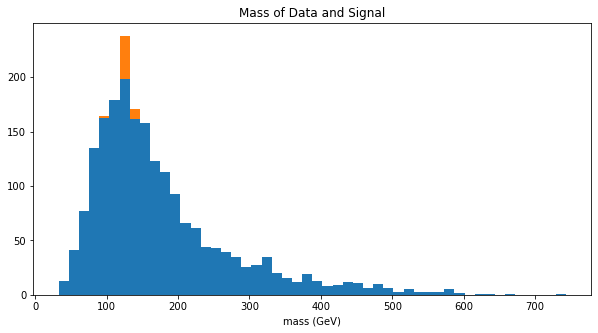

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd 

qcd_mass = bkgd['mass'][0:2000]
signal_mass = signal['mass'][0:50]
higgs_mass = 125.09
plt.figure(figsize=(10,5))
val, edges, temp = plt.hist([qcd_mass, signal_mass], bins=50, stacked=True)
plt.title("Mass of Data and Signal")
plt.xlabel('mass (GeV)')

print("Significance: ", stats.norm.ppf(stats.poisson.cdf(2050, 50)))  # Expected signifcance
print("\nExpected significance: ", 50/np.sqrt(2000))  # compare to N-Higgs/sqrt(N-qcd) from spec

The measured significance is about twice the calculated significance below the mean. 

## Part 2

In [3]:
# Mass cuts
# - making symmetric cuts of increasing widths of 10 GeV up to +-580 GeV from the mean of signal+bkgd

significances = []
for i in np.arange(1,30):
    lower = higgs_mass - i*0.5
    upper = higgs_mass + i*0.5
    new_qcd = [n for n in qcd_mass if n > lower and n < upper]
    new_signal = [n for n in signal_mass if n > lower and n < upper]
    k = len(new_qcd) + len(new_signal)
    mu = len(new_qcd)
    sig = stats.norm.ppf(stats.poisson.cdf(k, mu))
    significances.append([sig, lower, upper])
significances = np.array(significances)
temp = np.max(significances[:,0])
print("Largest significance: ", temp)
index = np.where(significances[:,0]==temp)[0][0]
upper_cut = significances[index,2]
lower_cut = significances[index,1]
print("Upper cut: ", upper_cut)
print("Lower cut: ", lower_cut)    

Largest significance:  3.135797303372643
Upper cut:  127.59
Lower cut:  122.59


## Part 3
### A) No event selection

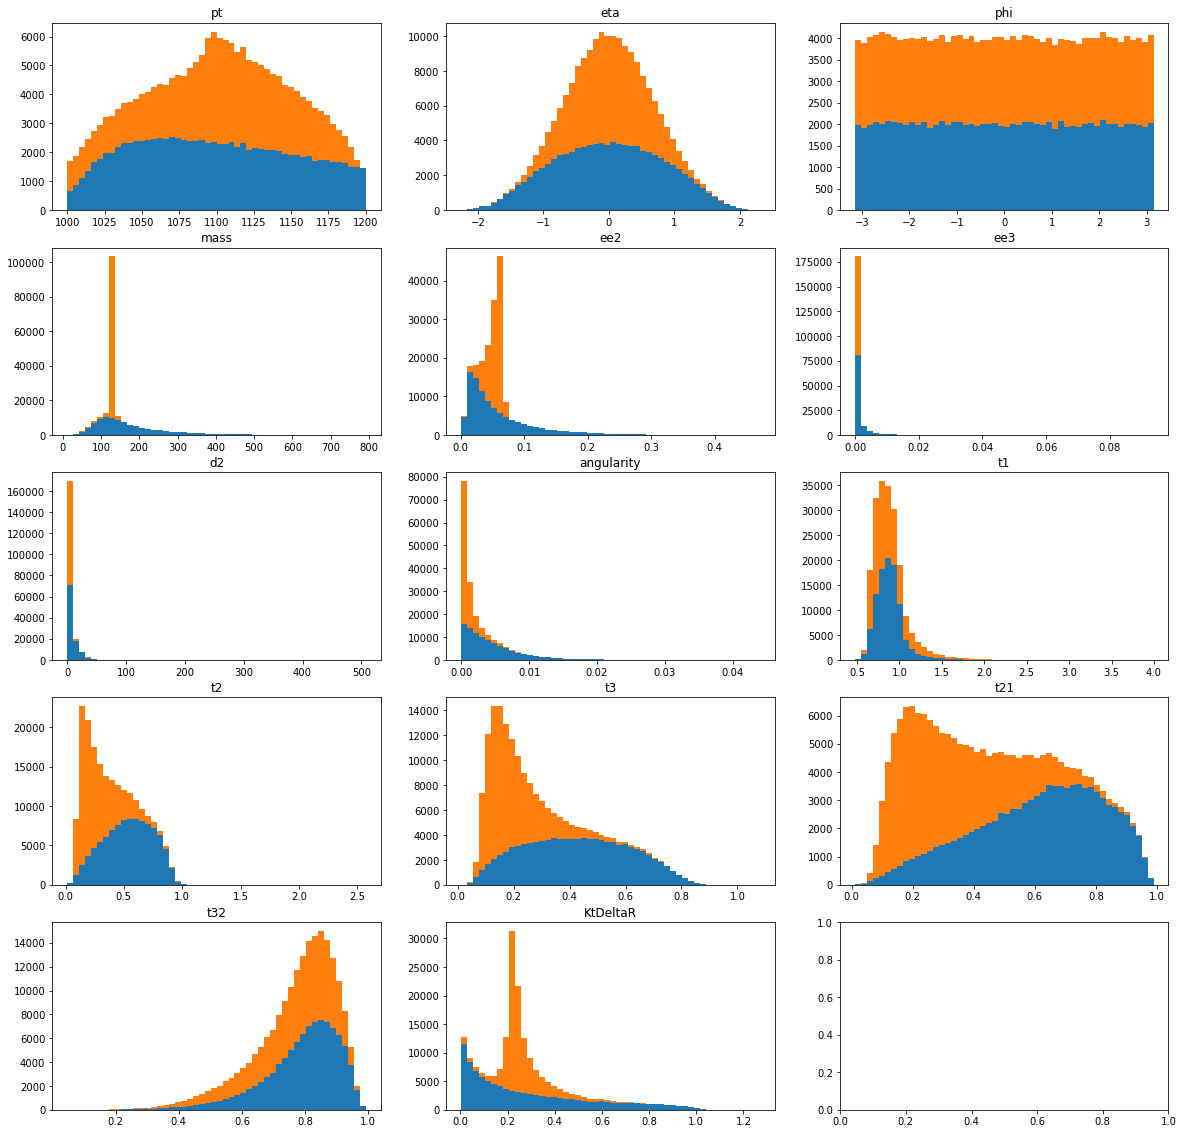

In [4]:
fig, ax = plt.subplots(5,3,figsize=(20,20))

# excluding mass
attributes = ['pt', 'eta', 'phi', 'mass', 'ee2', 'ee3', 'd2', 'angularity', 't1', 't2', 't3', 't21', 't32', 'KtDeltaR']
index = 0
for row in range(5):
    for col in range(3):
        ax[row,col].hist([bkgd[attributes[index]], signal[attributes[index]]], 50, stacked=True)
        ax[row,col].set_title(attributes[index])
        index += 1
        if row==4 and col==1: break

plt.show()

Feature(s) that are more discriminative are KtDeltaR, ee2, t2, t3, t21, and angularity. 

### B) With mass cuts

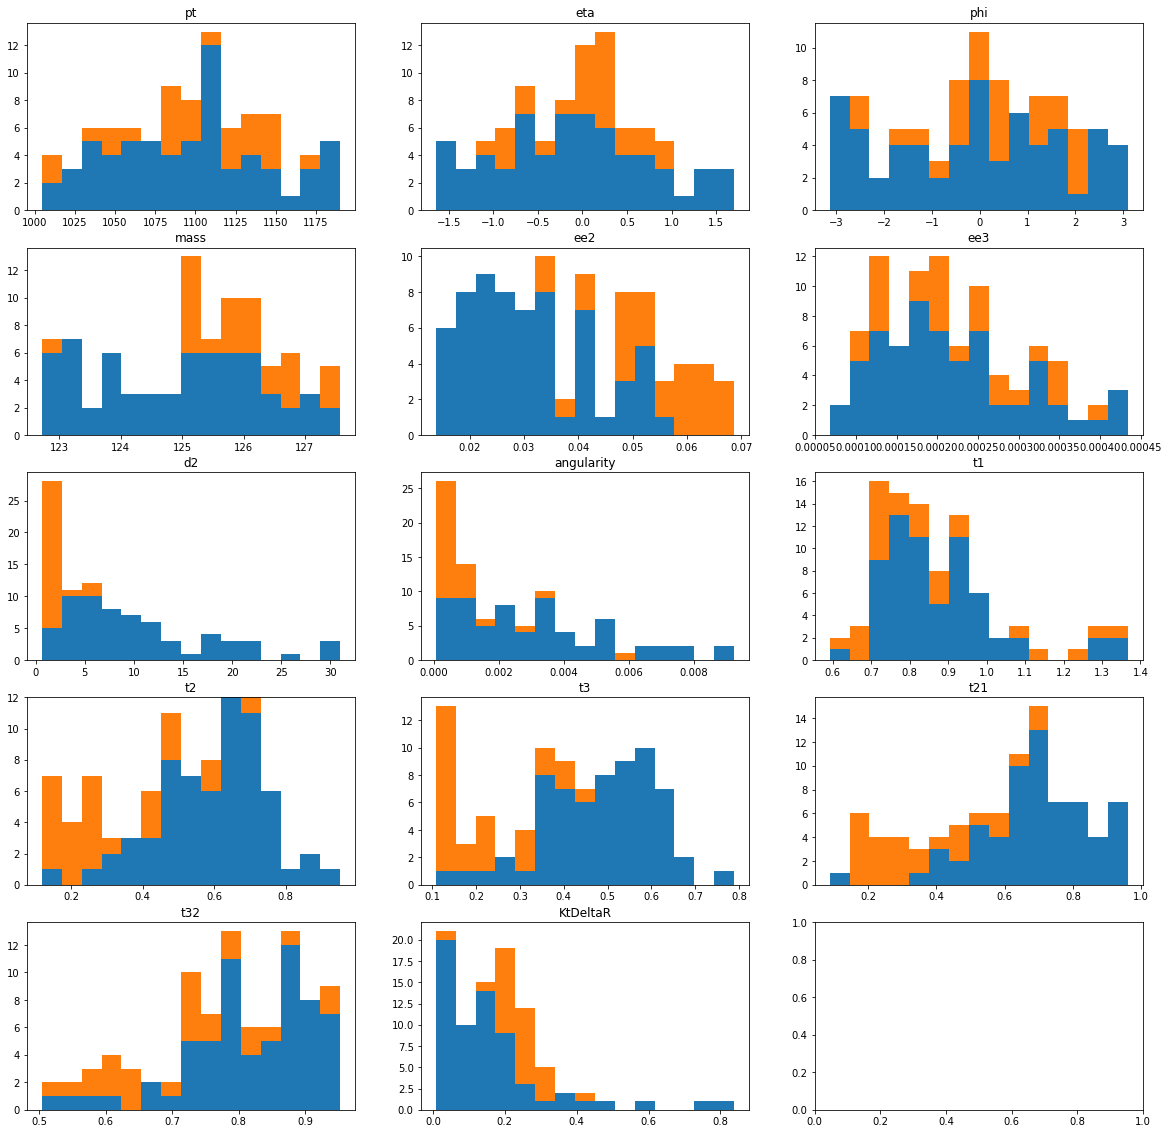

In [5]:
fig, ax = plt.subplots(5,3,figsize=(20,20))

qcd = bkgd[0:2000].copy()
higgs = signal[0:50].copy()
        
# Mass cuts for qcd
for index, row in qcd.iterrows():
    if row['mass'] < lower_cut or row['mass'] > upper_cut:
        qcd.drop(index, inplace=True)
        
# Mass cuts for higgs
for index, row in higgs.iterrows():
    if row['mass'] < lower_cut or row['mass'] > upper_cut:
        higgs.drop(index, inplace=True)

# plotting histograms
index = 0
for row in range(5):
    for col in range(3):
        ax[row,col].hist([qcd[attributes[index]], higgs[attributes[index]]], 15, stacked=True)
        ax[row,col].set_title(attributes[index])
        index += 1
        if row==4 and col==1: break

plt.show()

From initial inspection of the plots above, d2, angularity, t2, t3, t21, and ee2 can be further cut. 

## Part 4

In [6]:
# Feature cuts

features = ['d2', 'angularity', 't2', 't3', 't21', 'ee2', 'pt']
cuts = [[0,3], [0,0.0015], [0,0.35], [0,0.25], [0.1,0.4], [0.045,0.07], [1080,1150]]  # hand-picked

for n in range(len(features)):
    qcd_pmc = qcd.copy()  # qcd post mass cut
    higgs_pmc = higgs.copy()
    
    # cut qcd given range from above    
    for index, row in qcd_pmc.iterrows():  
        if row[features[n]] < cuts[n][0] or row[features[n]] > cuts[n][1]:
            qcd_pmc.drop(index, inplace=True)
    
    # cut signal
    for index, row in higgs_pmc.iterrows():  
        if row[features[n]] < cuts[n][0] or row[features[n]] > cuts[n][1]:
            higgs_pmc.drop(index, inplace=True)
    
    k = len(qcd_pmc) + len(higgs_pmc)
    mu = len(qcd_pmc)
    print('\n', features[n])
    print('#qcd: ', len(qcd_pmc), '\n#higgs: ', len(higgs_pmc))
    print('Significance: ', stats.norm.ppf(stats.poisson.cdf(k, mu)))


 d2
#qcd:  5 
#higgs:  23
Significance:  7.27745662028784

 angularity
#qcd:  19 
#higgs:  22
Significance:  4.487835462394618

 t2
#qcd:  5 
#higgs:  17
Significance:  5.772109197787486

 t3
#qcd:  3 
#higgs:  18
Significance:  6.968907698526276

 t21
#qcd:  2 
#higgs:  17
Significance:  7.407414076138096

 ee2
#qcd:  10 
#higgs:  21
Significance:  5.453990225591132

 pt
#qcd:  30 
#higgs:  17
Significance:  2.970143659306863


Before our mass cut, our expected discovery sensitivity was about 1.118.

After making the initial mass cut, the sensitivty increased to 3.136. 

After the feature cuts, the largest significance is 7.407 on the __t21__ feature.

## Part 5

Problem: Can you find a curve or a linear combination in this 2D plane which gives even better sensitivity?

Extended reading: Lab 7 is a classificaition problem using multi-dimensional features in supervised machine learning. We can use popular machine learning tools to develop an optimial classifier which can maximize information by using all features. For interested students, you can read https://scikit-learn.org/stable/supervised_learning.html

0.01953290055482839 1.518506266187616
0.0023530573396570195 0.28923058273468183


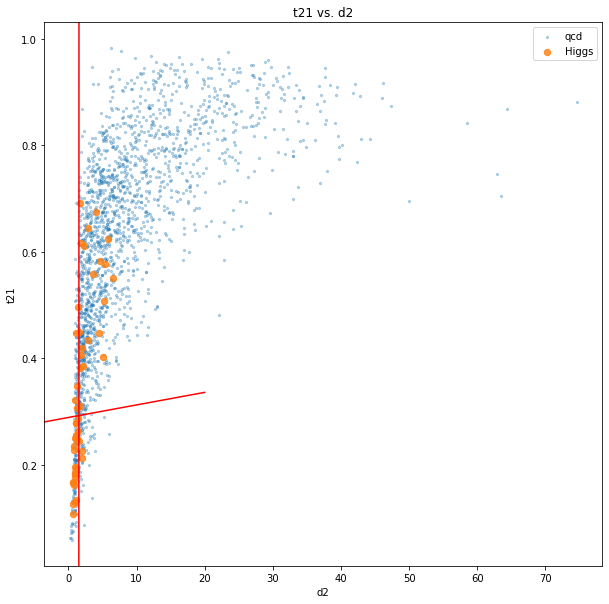

In [151]:
# From previous cell, determined d2 and t21 to be most significant.
# Plotting without mass cuts

plt.figure(figsize=(10,10))
plt.scatter(bkgd['d2'][0:2000], bkgd['t21'][0:2000], alpha=0.3, s=5)
plt.scatter(signal['d2'][0:50], signal['t21'][0:50], alpha=0.8, s =40)
plt.title("t21 vs. d2")
plt.xlabel('d2')
plt.ylabel('t21')
plt.legend(['qcd','Higgs'])

# Linear fit
space = np.linspace(0,50)
x = signal['d2'][0:50]
y = signal['t21'][0:50]
m1, b1 = np.polyfit(space, x, 1)
m2, b2 = np.polyfit(space, y, 1)
print(m1, b1)  # d2
print(m2, b2)  # t21
xlin = np.linspace(-10,20)
plt.autoscale(False)
plt.plot(m1*xlin+b1, xlin, 'r')
plt.plot(xlin, m2*xlin+b2, 'r')
plt.show()

In [145]:
# Sklearn
from sklearn import linear_model, metrics

reg = linear_model.LinearRegression()
x = np.reshape(x.to_numpy(), (-1,1))
reg.fit(x, y)
print('slope: ', reg.coef_, 'intercept: ', reg.intercept_)
x_test = [[1], [1], [1], [1]]
y_test = [[0.3], [0.2], [0.5], [0.4]]
pred = reg.predict(x_test)
print(pred)  # test, predicted
print(reg.score(x_test, y_test))

## incomplete

slope:  [0.07623691] intercept:  0.19506258179763744
[0.2712995 0.2712995 0.2712995 0.2712995]
-0.4955015407139884
